In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3231140513691313591
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5713690624
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10150508766041086752
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [3]:
train_ds, test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './vangogh2photo/', 
    batch_size = 1, 
    crop_to_aspect_ratio = True, 
    validation_split = 0.1, 
    subset = 'both', 
    seed = 0
)
train_ds, test_ds

Found 1151 files belonging to 2 classes.
Using 1036 files for training.
Using 115 files for validation.


(<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [5]:
for i, name in enumerate(train_ds.class_names):
    print(f'{i} - {name}')

0 - foto
1 - vangogh


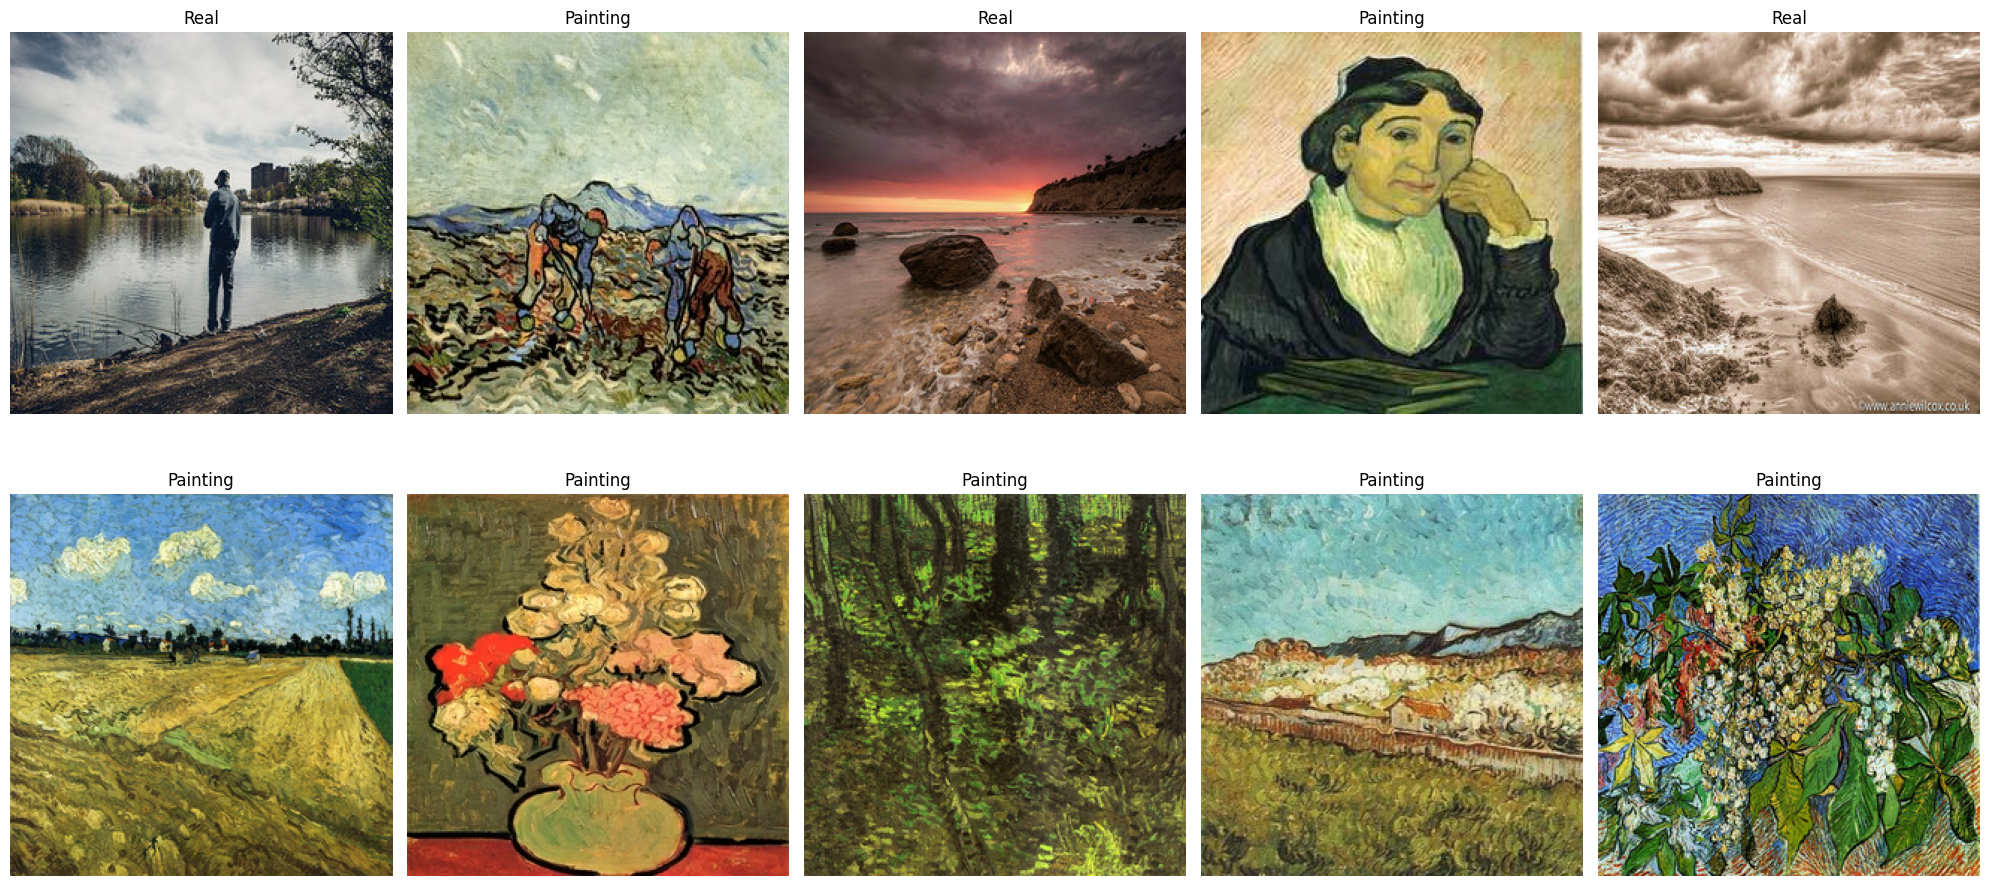

In [6]:
plt.figure(figsize=(20, 10))
for i, (image, label) in enumerate(train_ds.take(10)):
    plt.subplot(2, 5, i+1)
    plt.imshow((image.numpy()[0]/255).astype('float'))
    plt.axis('off')
    plt.title('Real' if label.numpy()==0 else 'Painting')
plt.tight_layout()

In [10]:
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_HEIGHT, IMAGE_WIDTH),
    tf.keras.layers.Rescaling(scale=1/255),
])

In [11]:
# Creo que no hace falta
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomContrast(factor=0.3)
])

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2, fill_mode='wrap'),
  tf.keras.layers.RandomZoom(0.2, 0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
  tf.keras.layers.Rescaling(1/255)
], name ='data_augmentation')

In [8]:
def prepare_dataset(ds, preprocess, augment=None):
    class_names = ds.class_names

    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (preprocess(x), y))

    # Use data augmentation only on the training set.
    if augment is not None:
        ds = ds.map(lambda x, y: (augment(x, training=True), y))

    # Batch all datasets.
    ds = ds.prefetch(tf.data.AUTOTUNE)
    ds.class_names = class_names
    return ds

In [13]:
training = prepare_dataset(train_ds, data_augmentation, augment=data_augmentation)
